## This notebook providtes an exploration of using Geweke or Rubin's tests for MCMC software

This notebook uses Random Walk Metropolis targeting a the posterior of a logistic model with normal noise

In [243]:
import os
os.chdir("..")
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
times = np.linspace(0, 1000, 10)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

# Create a normal prior over the parameters
log_prior = pints.ComposedLogPrior(pints.NormalLogPrior(mean=0.015, standard_deviation=0.0002),
                                   pints.NormalLogPrior(mean=500, standard_deviation=10))
# log_prior = pints.UniformLogPrior(
#     [0.01, 400],
#     [0.02, 600]
# )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Choose a covariance matrix for the proposal step
sigma0 = [0.015 * 5e-4, 1]

# Create mcmc routine
mcmc = pints.MetropolisRandomWalkMCMC(real_parameters * 1.1, sigma0)

## Geweke method

### Successive-conditional simulator

In [261]:
n = 400000
theta = np.zeros((n, 2))
y = np.zeros((n, len(values)))
for i in range(n):
    org_values = model.simulate(params, times)
    values1= org_values + np.random.normal(0, noise, org_values.shape)
    log_posterior.log_likelihood()._values = values1
    log_posterior.log_likelihood()._problem._values = values1
    params = mcmc.ask()
    params = mcmc.tell(log_posterior(params))
    theta[i, :] = params
    y[i, :] = values1

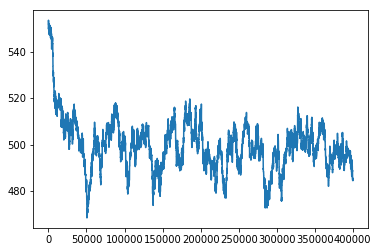

In [271]:
plt.plot(theta[:, 1])
plt.show()

### marginal conditional estimator (just sampling from the prior if g(theta,y)=g(theta))

In [263]:
theta1 = log_prior.sample(n=n)

### Geweke comparison between results

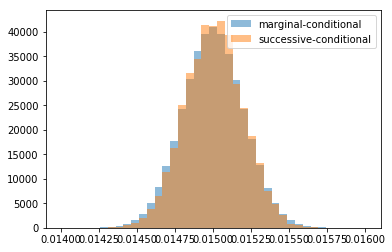

In [264]:
a_axis = 0
bins = np.linspace(0.014, 0.016, 40)
plt.hist(theta1[:, a_axis], bins, alpha=0.5, label='marginal-conditional')
plt.hist(theta[:, a_axis], bins, alpha=0.5, label='successive-conditional')
plt.legend(loc='upper right')
plt.show()

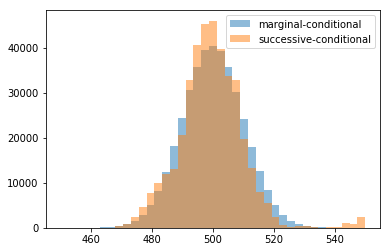

In [265]:
a_axis = 1
bins = np.linspace(450, 550, 40)
plt.hist(theta1[:, a_axis], bins, alpha=0.5, label='marginal-conditional')
plt.hist(theta[:, a_axis], bins, alpha=0.5, label='successive-conditional')
plt.legend(loc='upper right')
plt.show()

### Examine first and second moments of each dimension

In [292]:
import scipy.stats
## calculates the LHS od eqn. (6) in Geweke et al.
def stat_generator(theta1, theta, moment=1):
    g_00 = np.mean(theta1**moment)
    g_10 = np.mean(theta**moment)
    sigma_00 = np.mean((theta1**moment)**2) - g_00**2
    sigma_10 = np.mean((theta**moment)**2) - g_10**2
    stat = (g_00 - g_10) / (((sigma_00 + sigma_10) / n)**0.5)
    return stat
def p_value_generator(theta1, theta, moment=1):
    return scipy.stats.norm.cdf(stat_generator(theta1, theta, moment))

def geweke_all_p(theta1, theta):
    p = np.zeros(4)
    p[0] = p_value_generator(theta1[:, 0], theta[:, 0], 1)
    p[1] = p_value_generator(theta1[:, 0], theta[:, 0], 2)
    p[2] = p_value_generator(theta1[:, 1], theta[:, 1], 1)
    p[3] = p_value_generator(theta1[:, 1], theta[:, 1], 2)
    return p

## tests all first and (all but 1 - the cross term as am being lazy) second moment at 1% level
def geweke_test_bonferroni(theta1, theta):
    p = geweke_all_p(theta1, theta)
    for a_p in p:
        if a_p < 0.005 / 4 or a_p > 0.995 / 4:
            return 1
    return 0

# test on raw data fails
print(geweke_test_bonferroni(theta1, theta))

# test on 2nd half (after burn-in) - still fails!
print(geweke_test_bonferroni(theta1[int(n / 2):, :], theta[int(n / 2):, :]))

1
1


## Geweke on my own Metropolis -- also fails! Clearly the second component of the successive-conditional simulator is too slow to converge for this algorithm

In [296]:
n = 400000
theta = np.zeros((n, 2))
y = np.zeros((n, len(values)))
params = real_parameters * 1.1
for i in range(n):
    org_values = model.simulate(params, times)
    values1= org_values + np.random.normal(0, noise, org_values.shape)
    log_posterior.log_likelihood()._values = values1
    log_posterior.log_likelihood()._problem._values = values1
    params_temp = np.random.multivariate_normal(params, np.diag(sigma0))
    r = np.exp(log_posterior(params_temp)-log_posterior(params))
    if r > np.random.rand():
        params = params_temp
    theta[i, :] = params
    y[i, :] = values1
theta1 = log_prior.sample(n=n)

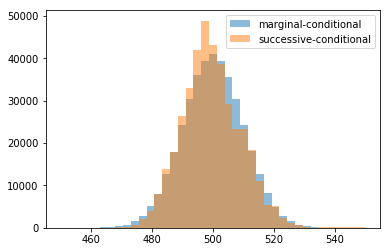

In [299]:
a_axis = 1
bins = np.linspace(450, 550, 40)
plt.hist(theta1[:, a_axis], bins, alpha=0.5, label='marginal-conditional')
plt.hist(theta[:, a_axis], bins, alpha=0.5, label='successive-conditional')
plt.legend(loc='upper right')
plt.show()

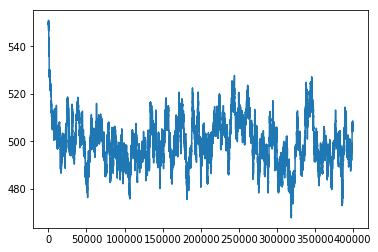

In [297]:
plt.plot(theta[:, 1])
plt.show()

In [298]:
print(geweke_all_p(theta1, theta))

[ 0.01229374  0.01201364  1.          1.        ]


## Plot distribution of y -- looks much better behaved!

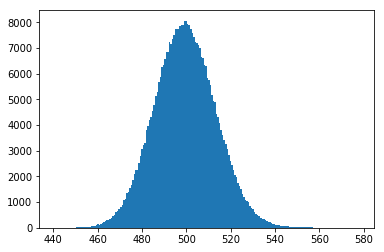

In [310]:
plt.hist(y[:, 9], 200)
plt.show()